In [1]:
input_dim = 13166
model_file = "model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
num_clusters = 4

import json
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf

import sys
sys.path.insert(0, "../Code/")
from explain import load_vae, explain, apply

def load_model(num_points, input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, num_points, feature_transform = "../Data/bipolar_pc.tsv")

import os
os.system("rm -rf tb")

0

In [2]:
###
# Load Data & Configuration
###

x = pd.read_csv("bipolar.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
###
# Approximate the original data
###

matrix = pd.read_csv("../Data/bipolar_pc.tsv", sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


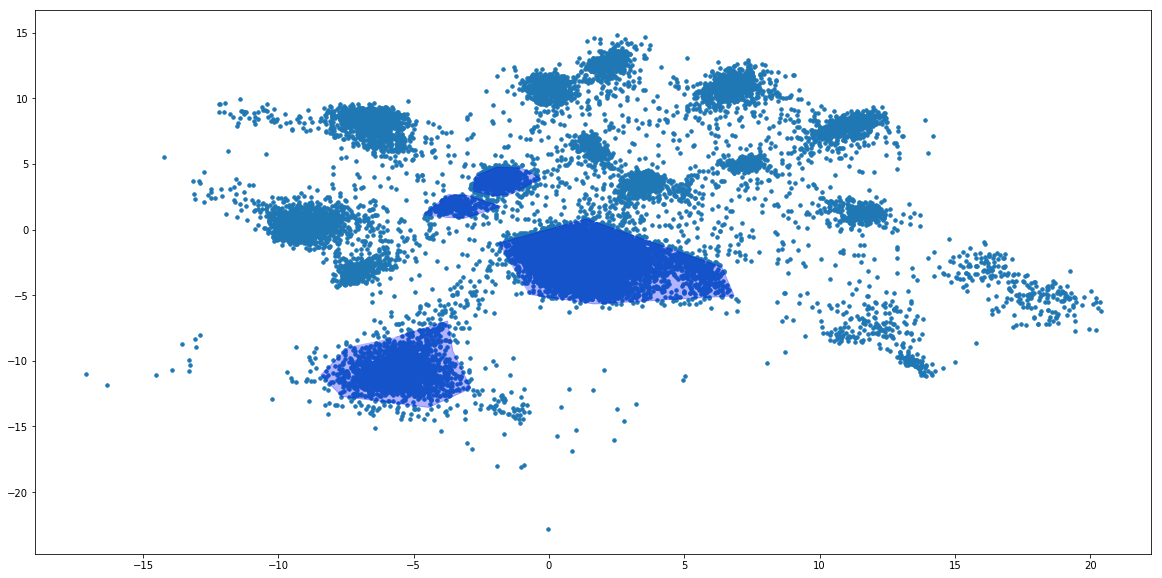

In [4]:
###
# Visualize the data and the marked clusters
###

sess, rep, X, delta_global, delta_ind = load_model(1)

data_rep = sess.run(rep, feed_dict={X: x_full})

fig, ax = plt.subplots(figsize=(20, 10))
patches = []

for i in range(num_clusters):
    line = plt.Polygon(all_vertices[i], closed=False, color="blue", alpha=0.3)
    ax.add_line(line)

plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12)

plt.show()
plt.close()

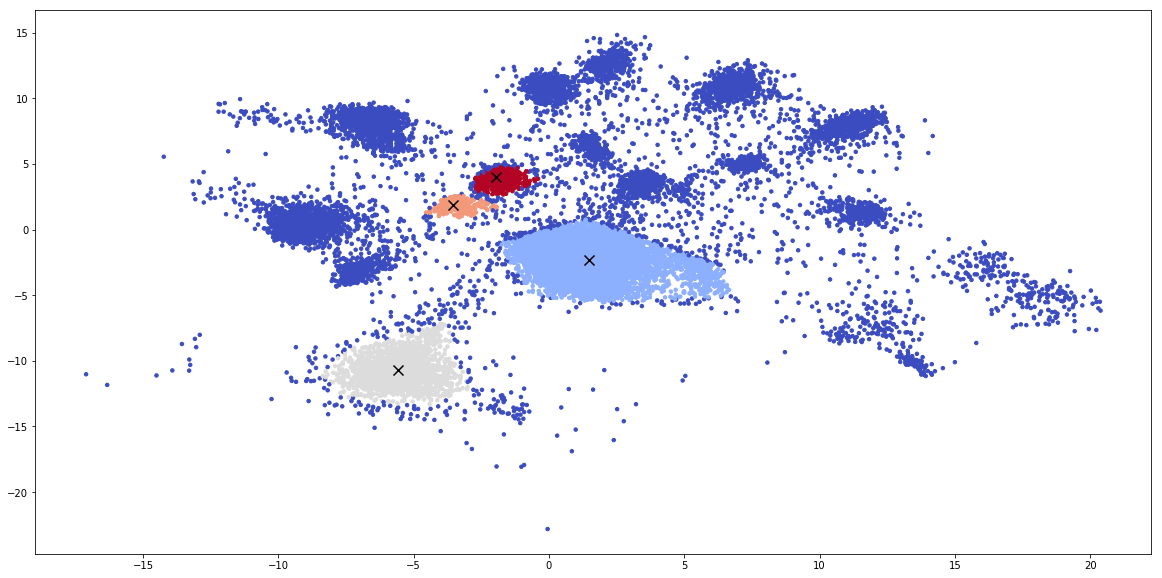

In [5]:
###
# Find the datapoints in each marked cluster
###

m = data_rep.shape[0]
cluster = -1.0 * np.ones((m))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
for i in range(num_clusters):
    path = Path(all_vertices[i])
    indices[i] = []
    for j in range(m):
        if path.contains_points(data_rep[j].reshape((1,2))):
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    
centers = np.array(centers)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)
plt.scatter(centers[:, 0], centers[:, 1], c = "black", marker = "x", s = 100)

plt.show()
plt.close()   

In [6]:
def run(load_model, x, y, indices, c1, c2, dispersion = 4.0, lambda_global = 6000.0, lambda_ind = 10000.0, k = 100):
    print("\nComputing the explanation\n")
    g, _ = explain(load_model, x, y, indices, c1, c2, dispersion = dispersion, lambda_global = lambda_global, lambda_ind = lambda_ind)
    print("\nTesting the global explanation on new points (no individual perturbation)\n")
    apply(load_model, x, y, indices, c1, np.expand_dims(g, 0))
    '''
    print("\nTesting an approximated global explanation on new points\n")
    idx = (-np.abs(g)).argsort()[:k]
    g_aprox = np.zeros((input_dim)) #input_dim is in the variable space
    g_aprox[idx] = g[idx]
    apply(load_model, x, y, indices, c1, np.expand_dims(g_aprox, 0))
    '''
    return g, 0 #g_aprox


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


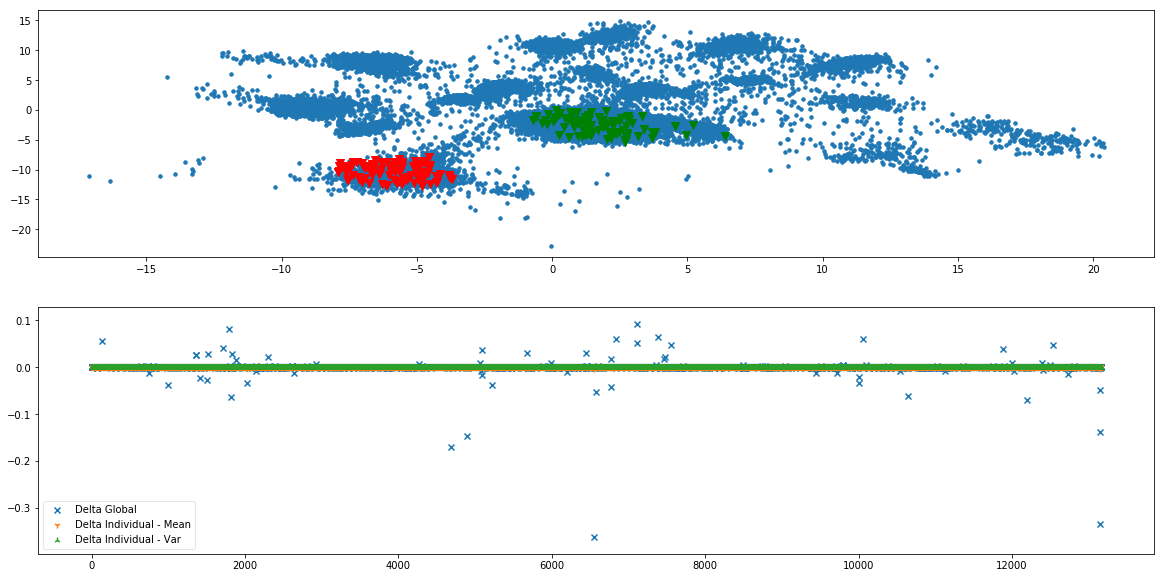


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


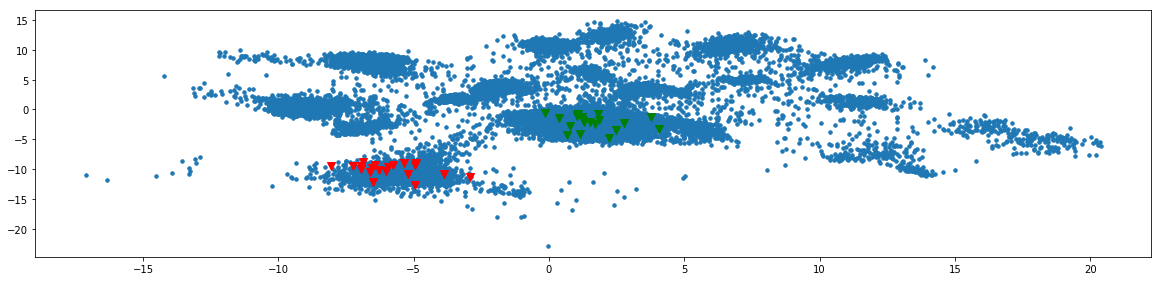

In [7]:
global_0_1, _ = run(load_model, x_full, data_rep, indices, 0, 1)


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


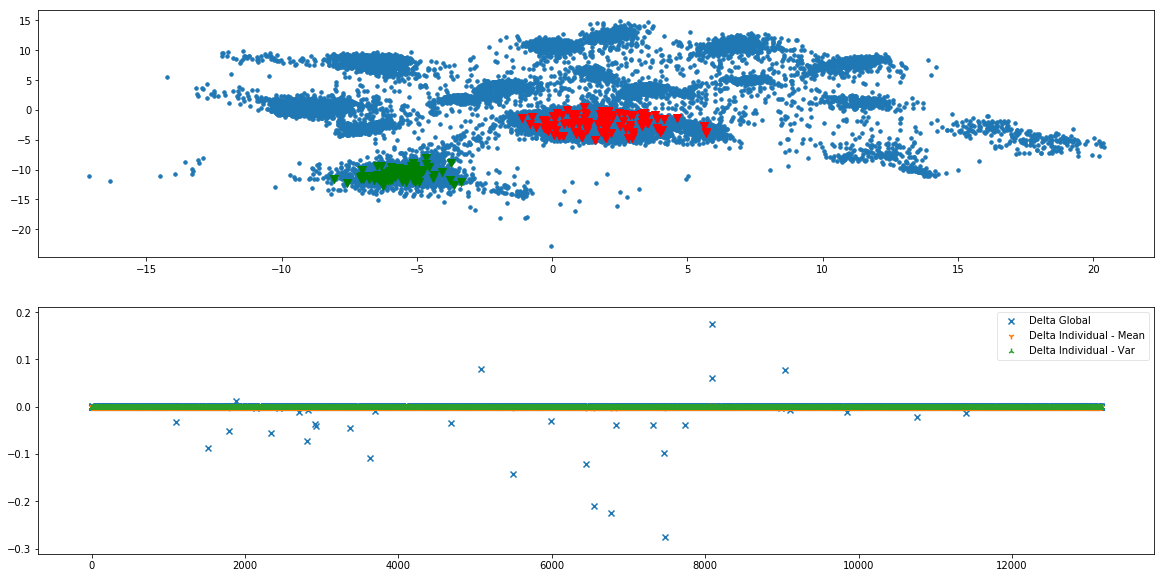


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


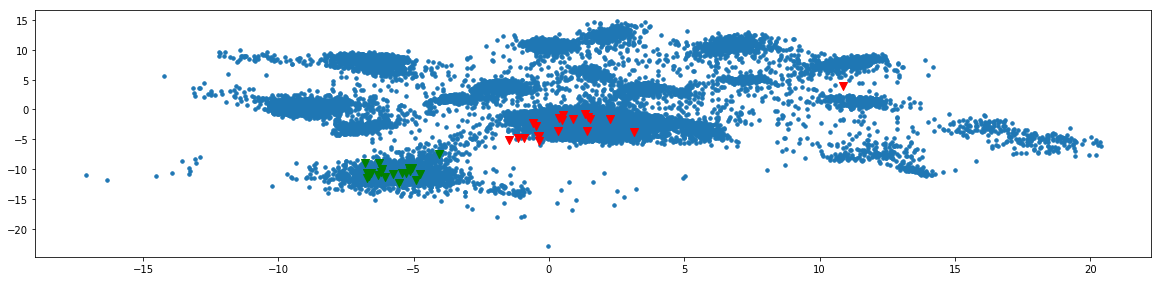

In [8]:
global_1_0, _ = run(load_model, x_full, data_rep, indices, 1, 0)


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


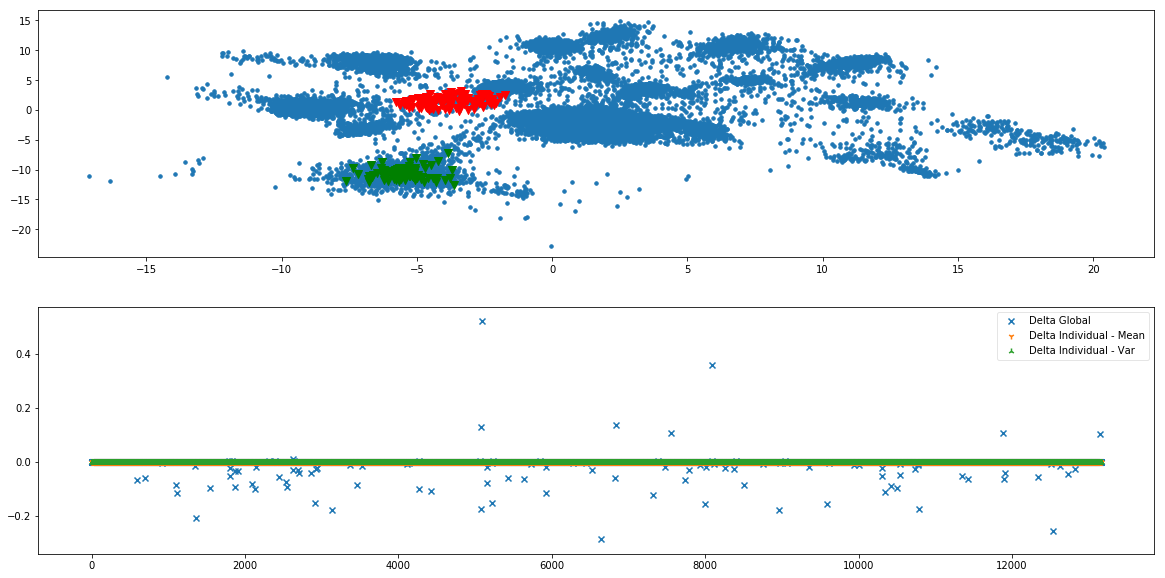


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


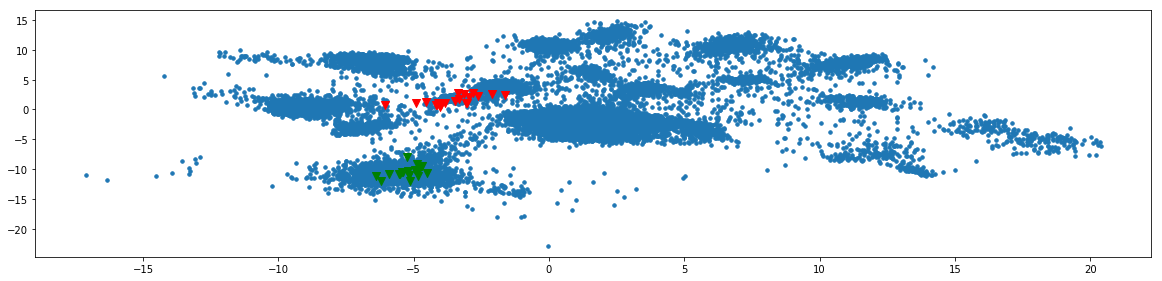

In [9]:
global_1_2, _ = run(load_model, x_full, data_rep, indices, 1, 2)


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


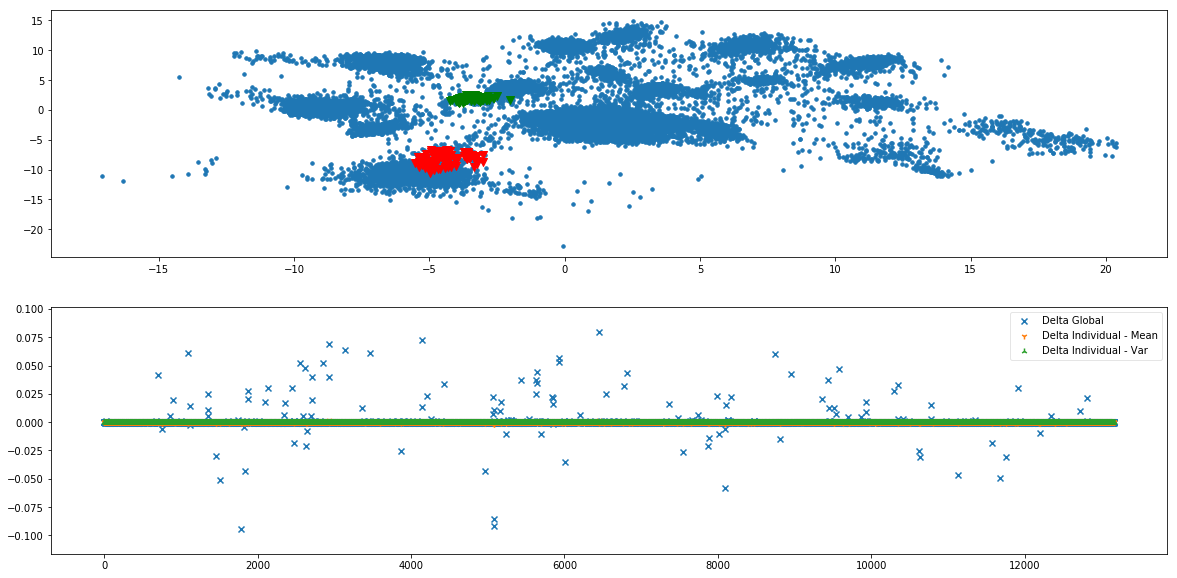


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


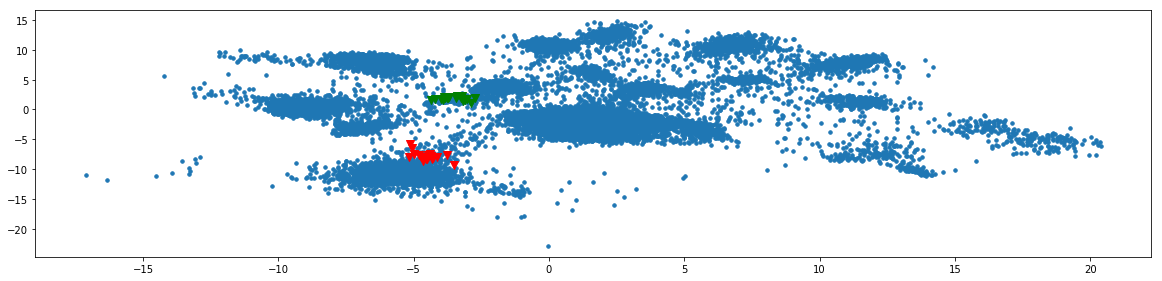

In [10]:
global_2_1, _ = run(load_model, x_full, data_rep, indices, 2, 1)


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


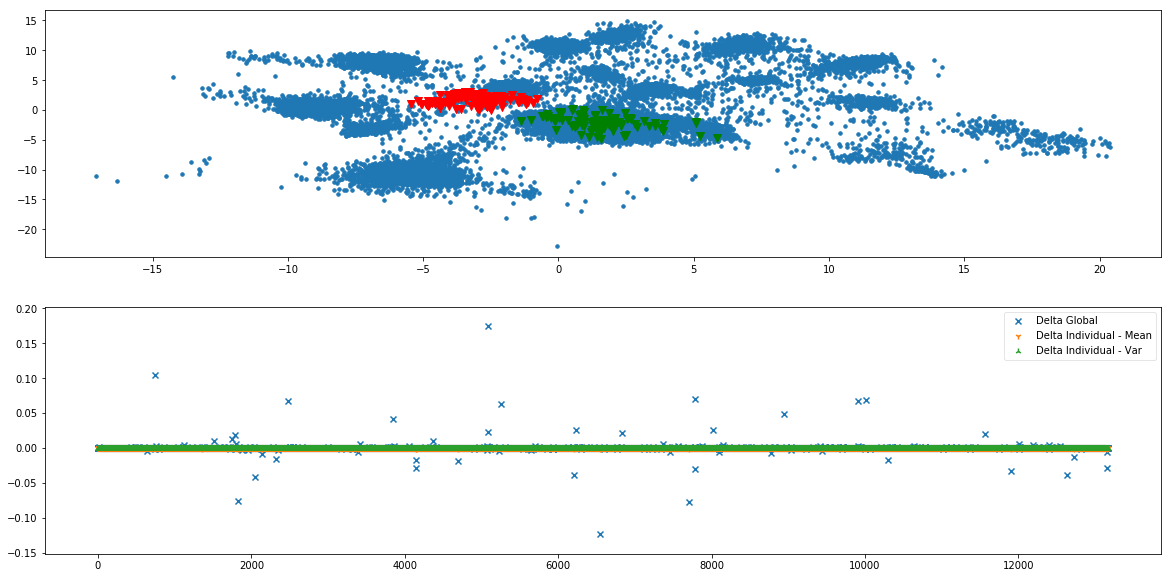


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


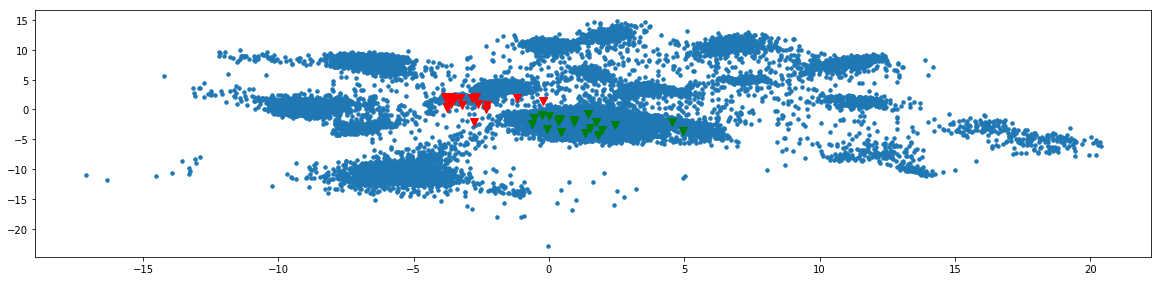

In [11]:
global_0_2, _ = run(load_model, x_full, data_rep, indices, 0, 2)


Computing the explanation

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from ./model.cpkt


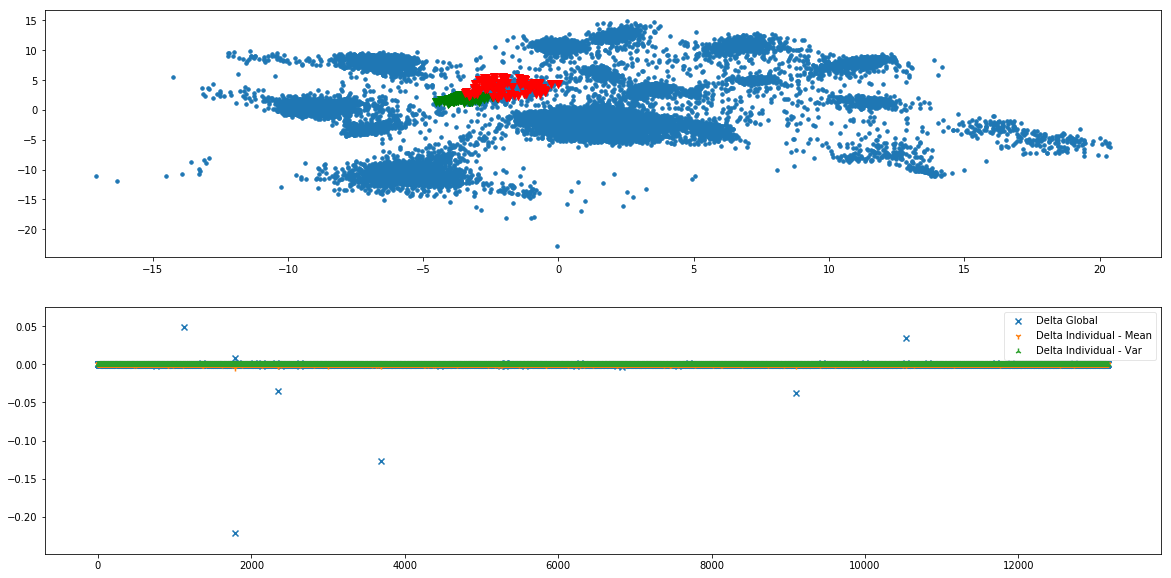


Testing the global explanation on new points (no individual perturbation)

INFO:tensorflow:Restoring parameters from model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


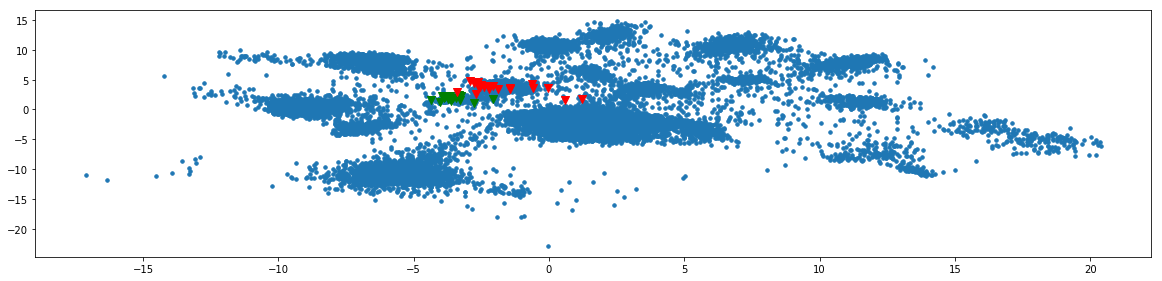

In [12]:
global_2_3, _ = run(load_model, x_full, data_rep, indices, 2, 3)

In [13]:
def scale(a2b, b2a):
    return (a2b + b2a) / (0.5 * np.sum(np.abs(a2b)) + 0.5 * np.sum(np.abs(b2a)))

def show(a2b, b2a):
    plt.hist(np.ndarray.flatten(scale(a2b, b2a)), bins = 100)
    plt.ylim(ymin = 0, ymax = 100)
    plt.show()
    plt.close()

From 0 to 1 and then 1 to 0


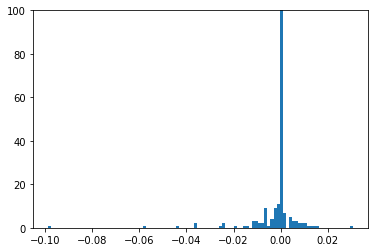

From 1 to 2 and then 2 to 1


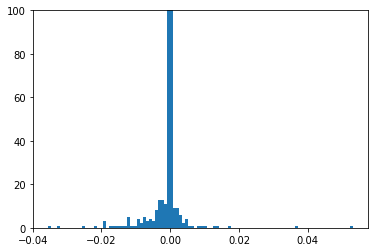

From 0 to 1 and then 1 to 2 compared to from 0 to 2


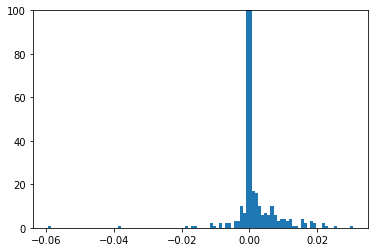

In [14]:
print("From 0 to 1 and then 1 to 0")
show(global_0_1, global_1_0)
print("From 1 to 2 and then 2 to 1")
show(global_1_2, global_2_1)
print("From 0 to 1 and then 1 to 2 compared to from 0 to 2")
show(global_0_2, -1.0 * (global_0_1 + global_1_2))